In [2]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
# load the dataset, explore the data, and clean the data as needed
data0 = pd.read_csv('spotify_songs.csv') 
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  32833 non-null  object 
 1   track_name                32828 non-null  object 
 2   track_artist              32828 non-null  object 
 3   track_popularity          32833 non-null  int64  
 4   track_album_id            32833 non-null  object 
 5   track_album_name          32828 non-null  object 
 6   track_album_release_date  32833 non-null  object 
 7   playlist_name             32833 non-null  object 
 8   playlist_id               32833 non-null  object 
 9   playlist_genre            32833 non-null  object 
 10  playlist_subgenre         32833 non-null  object 
 11  danceability              32833 non-null  float64
 12  energy                    32833 non-null  float64
 13  key                       32833 non-null  int64  
 14  loudne

In [6]:
# prepare dataset for analysis
data = data0.copy()

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

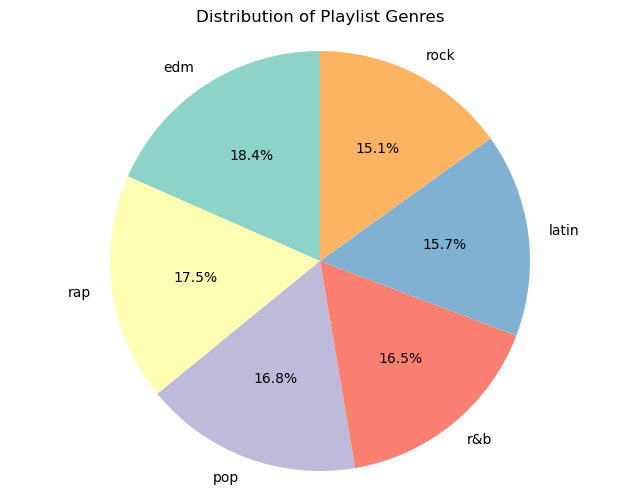

In [10]:
# EDA
# display playlist genres 
plt.figure(figsize=(8, 6))
genre_counts = data['playlist_genre'].value_counts()
plt.pie(genre_counts, labels=genre_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3", len(genre_counts)))
plt.title("Distribution of Playlist Genres")
plt.axis('equal') 
plt.savefig('Distribution of Playlist Genres')
plt.show()

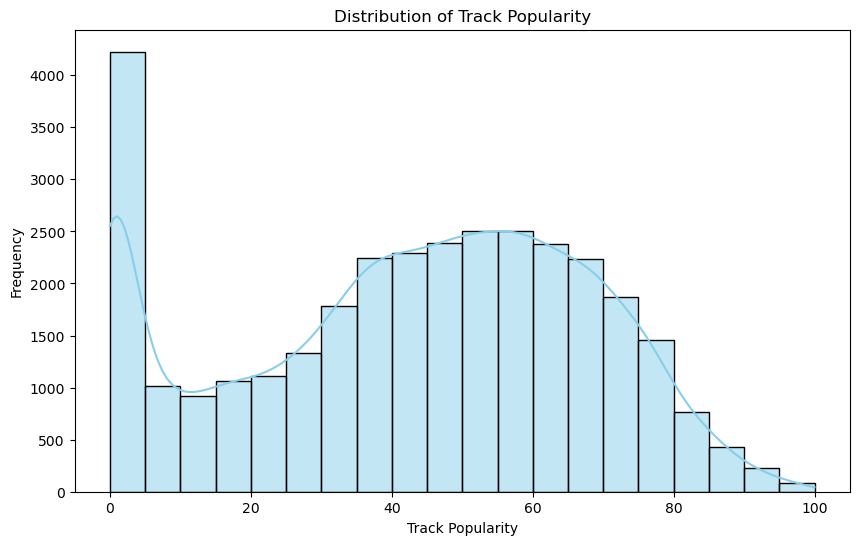

In [12]:
# display popularity 
plt.figure(figsize=(10, 6))
sns.histplot(data['track_popularity'], kde=True, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Track Popularity")
plt.xlabel("Track Popularity")
plt.ylabel("Frequency")
plt.savefig('Distribution of Track Popularity')
plt.show()

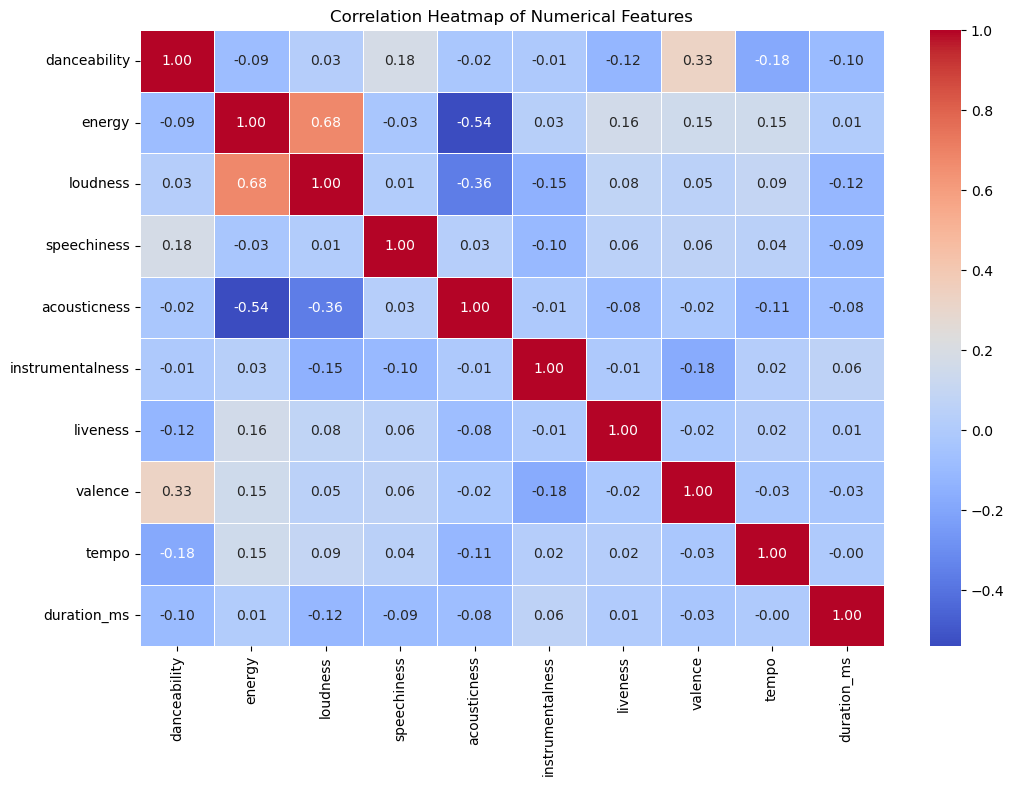

In [13]:
plt.figure(figsize=(12, 8))
corr_matrix = data[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
                     'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.savefig('Correlation Heatmap of Numerical Features')
plt.show()

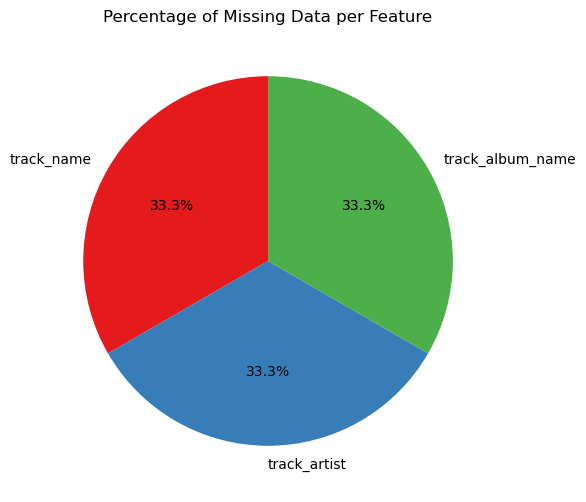

In [15]:
missing_data = data.isnull().sum()
missing_data_percentage = (missing_data / len(data)) * 100
missing_data_percentage = missing_data_percentage[missing_data_percentage > 0]  # Only show features with missing data
plt.figure(figsize=(8, 6))
missing_data_percentage.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set1", len(missing_data_percentage)))
plt.title("Percentage of Missing Data per Feature")
plt.ylabel('')
plt.savefig('Percentage of Missing Data per Feature')
plt.show()


In [16]:
# prep the data 
data.dropna(inplace=True)
X = data[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
          'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].values
y = pd.factorize(data['playlist_genre'])[0] 

In [18]:
# PCA for feature selection
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

In [20]:
# initiate k-fold for CV
n_splits = 5  
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

In [22]:
# create recommendation models
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM": SVC(kernel='linear', probability=True),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, n_jobs=-1)
}

results_cv = {}

In [24]:
# perform CV
def cross_validate_model_with_metrics(model, X, y, model_name):
    metrics = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': [], 'ROC AUC': [], 'Train Time': [], 'Predict Time': []}
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        start_train = time.time()
        model.fit(X_train, y_train)
        end_train = time.time()

        start_predict = time.time()
        y_pred = model.predict(X_test)
        
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)
            if y_pred_proba.shape[1] == 2: 
                y_pred_proba = y_pred_proba[:, 1]
            else:
                y_pred_proba = y_pred_proba
        else:
            y_pred_proba = y_pred  

        end_predict = time.time()

        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred, average='weighted', zero_division=0))
        metrics['Recall'].append(recall_score(y_test, y_pred, average='weighted', zero_division=0))
        metrics['F1-Score'].append(f1_score(y_test, y_pred, average='weighted', zero_division=0))
        
        if hasattr(model, "predict_proba"):
            metrics['ROC AUC'].append(roc_auc_score(y_test, y_pred_proba, multi_class='ovr') if len(np.unique(y)) > 2 else roc_auc_score(y_test, y_pred_proba))
        else:
            metrics['ROC AUC'].append(np.nan)

        metrics['Train Time'].append(end_train - start_train)
        metrics['Predict Time'].append(end_predict - start_predict)
    
    results_cv[model_name] = {metric: f"{np.mean(scores):.4f} ± {np.std(scores):.4f}" for metric, scores in metrics.items()}


In [ ]:
# perform the models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    cross_validate_model_with_metrics(model, X_pca, y, model_name)

results_cv_df = pd.DataFrame(results_cv).T
print("\nCross-Validation Results with PCA:")
print(results_cv_df)     


Training KNN...
Training Naive Bayes...
Training SVM (Linear)...
